In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本,形状为50的张量，且元素的范围为0-5

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [5]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

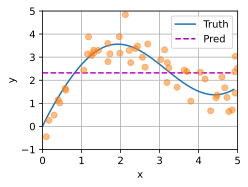

In [6]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

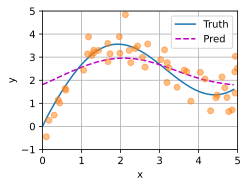

In [7]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)